# Segmenting images

Image segmentation is the process of partitioning an image into multiple segments or regions. The goal of segmentation is to simplify the representation of an image into meaningful parts, which can then be analyzed individually. This technique is commonly used in computer vision tasks for various applications such as object detection, recognition, and scene understanding.

In this notebook, we aim to segment images featuring individual bottles, focusing on identifying and delineating the contours of each bottle within the image.

## 1) Load packages

We start by loading a standard set of Python libraries, and install and load [keras_unet](https://github.com/karolzak/keras-unet), a package for image segmentation tasks with a number of useful helper functions.

In [1]:
# Suppressing warnings to maintain clean output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import packages
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Import keras_unet package, to be used for image segmentation
import keras_unet

2024-05-11 11:34:59.810484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## 2) Load data for segmentation model

In [4]:
# Retrieve directory where we will get save processed data and features
parent_directory = os.path.abspath('../')

# Directory for saved features
features_path = os.path.join(parent_directory,'data/features')
os.makedirs(features_path, exist_ok=True)

# Directory for saved models
saved_models_path = os.path.join(parent_directory,'saved_models')
os.makedirs(saved_models_path, exist_ok=True)

Next, we load the images and masks for the images of bottles we set aside in notebooks 1 and 2.

We use the images created with **widen_param=0.05**, meaning that our objects will be in the **center of the image** but we retain some of the **image background** beyond the annotation bounding box. As a reminder, we also restricted the sample to images with **only one bottle**. Therefore, the model will not encounter any images containing two or more objects to segment.

In [5]:
# Load the processed (cropped+framed) images
with np.load("{}/{}/{}".format(features_path,"widen_param_0.05","classification-images.npz"), allow_pickle=True) as npz_file:
    # It's a dictionary-like object
    print(list(npz_file.keys()))

    # Load the arrays
    s1_images = npz_file["s1"]
    s1_masks = npz_file["s1_masks"]

['c1', 's1', 's1_masks']


## 3) Plotting images (X) and masks (Y)

The image masks have the same shape as the corresponding images (224x224 pixels), and each pixel has either a value of 0 (if it's outside of the object) or 1 (if it's inside of the object). A key difference is that our images are in colour (and therefore have three colour channels) whereas the masks only have one colour channel or dimension.

We rescale the images so the value in each image pixel is between 0 and 1, and set set the data type for the masks to integers.

In [6]:
# Pre-process masks and images
s1_masks = s1_masks.astype(np.uint8)
s1_images = s1_images*1./255.

In [7]:
"Shape of images array: {}, Shape of masks array: {}".format(s1_images.shape,s1_masks.shape)

'Shape of images array: (248, 224, 224, 3), Shape of masks array: (248, 224, 224, 1)'

Then we plot 10 images from our set using the plot_imgs function, showing the original image and its mask side by side. We also show the overlay, with the mask on top of the original image. This is a useful sense check, to verify that our images and masks have been processed properly.

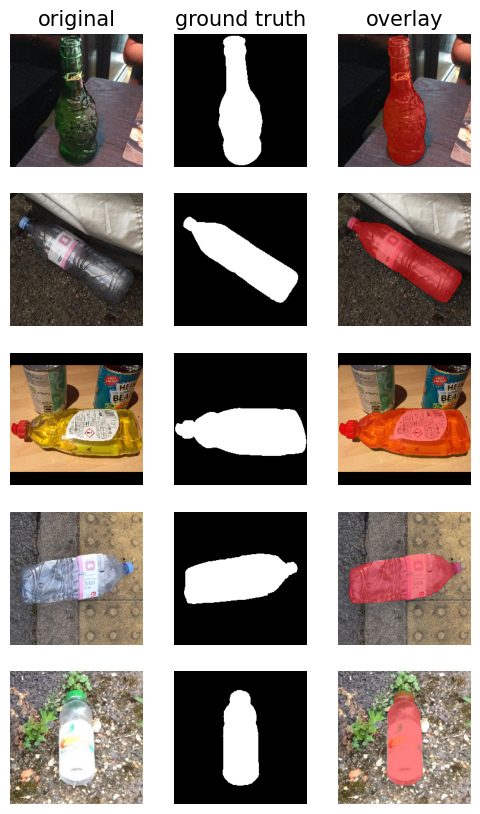

In [8]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=s1_images, mask_imgs=s1_masks, nm_img_to_plot=5, figsize=2)

## 4) Splitting data into train, validation and test sets

In these models, our predictors (X) will be the images and the outcome (Y) will be the image masks. As opposed to our previous classification problems, here we will be making predictions at the _pixel_ level rather than at the image level. Indeed, we are predicting whether each pixel is located inside the bottle (Y=1) or outside the bottle (Y=0).

First, we split the data into two sets: a combined training/validation set (90%) and a test set (10%). Then, we split the combined training/validation set into training (80%) and validation sets (20%). The resulting training set has 178 images, the validation set has 45 images and the testing set has 25 images.

In [9]:
from sklearn.model_selection import train_test_split

# Split data into training/validation sets and a test set
x_trainval, x_test, y_trainval, y_test = train_test_split(
    s1_images, s1_masks, test_size=0.1, random_state=8)

# Further split the training/validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_trainval, y_trainval, test_size=0.2, random_state=8)

# Print the shapes of the resulting datasets
print("x_test: {}, y_test: {}".format(x_test.shape, y_test.shape))
print("x_train: {}, y_train: {}".format(x_train.shape, y_train.shape))
print("x_val: {}, y_val: {}".format(x_val.shape, y_val.shape))

x_test: (25, 224, 224, 3), y_test: (25, 224, 224, 1)
x_train: (178, 224, 224, 3), y_train: (178, 224, 224, 1)
x_val: (45, 224, 224, 3), y_val: (45, 224, 224, 1)


## 5) Setting up a convolutional neural network for image segmentation

In [10]:
# Import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

We specify a convolutional neural network with a U-net architecture for our segmentation task, drawing from a [tutorial](https://www.machinelearningnuggets.com/image-segmentation-with-u-net-define-u-net-model-from-scratch-in-keras-and-tensorflow/) on image segmentation using Keras written by Derrick Mwiti.

- First, the model receives an input image of size 224x224x3, with the third dimension representing the three colour channels.

- Then, there is a contraction path which involves downsampling the input image and extracting increasingly abstract features. The number of filters in each block goes from 16 to 256. Between each block, a Max Pooling operation with stride 2 reduces the spatial resolution by half.

 - Traditional convolutional neural networks with pooling layers and dense layers are not suitable for image segmentation tasks because they discard **spatial information**, which is important to identify *where* objects are located in an image. U-Net models, however, are designed to preserve spatial information by upsampling the image, which enables the model to capture *where* objects might be located.

- Following the contraction path, the expansive path involves upsampling the features back to the original image size using transposed convolutions. Finally, a sigmoid activation function generates the binary segmentation mask.

In [11]:
# Define the convolutional block
def conv_block(x, filters):
    # Convolutional layer with ReLU activation and He normal weight initialization
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    # Dropout layer with dropout rate of 0.1
    x = tf.keras.layers.Dropout(0.1)(x)
    # Convolutional layer with ReLU activation and He normal weight initialization
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    # Batch normalization layer
    x = tf.keras.layers.BatchNormalization()(x)
    # ReLU activation layer
    x = tf.keras.layers.ReLU()(x)
    return x

# Define the up-convolutional block
def upconv_block(x, skip, filters):
    # Transposed convolutional layer (up-convolution) with stride of 2x2 and padding to maintain the spatial dimensions
    x = tf.keras.layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
    # Concatenate the up-convolved feature maps with the skip connection from the contracting path
    x = tf.keras.layers.concatenate([x, skip])
    # Batch normalization layer
    x = tf.keras.layers.BatchNormalization()(x)
    # ReLU activation layer
    x = tf.keras.layers.ReLU()(x)
    return x

# Define the input layer
inputs = tf.keras.layers.Input((224, 224, 3))

# Contraction path
c1 = conv_block(inputs, 16)  # First convolutional block with 16 filters
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)  # Second convolutional block with 32 filters
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)  # Third convolutional block with 64 filters
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)  # Fourth convolutional block with 128 filters
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)  # Fifth convolutional block with 256 filters

# Expansive path
u6 = upconv_block(c5, c4, 128)  # First up-convolutional block with 128 filters
u7 = upconv_block(u6, c3, 64)   # Second up-convolutional block with 64 filters
u8 = upconv_block(u7, c2, 32)   # Third up-convolutional block with 32 filters
u9 = upconv_block(u8, c1, 16)   # Fourth up-convolutional block with 16 filters

# Output
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(u9)

# Define the U-Net model
unet_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

2024-05-11 11:35:02.713253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 6) Data augmentation

We will use the 'get_augmented' function from the keras_unet package to artificially augment our training data. By generating "new" images, data augmentation can improve the model's performance and generalizability. This helps the model learn more robust representations of the data and reduce overfitting.

In [12]:
# Create an augmented images generator for the training set
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train,
    batch_size=3,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

Our augmented images generator output three images at a time, and we plot a sample of those augmented images to check that the spatial relationships in the masks have been preserved.

(3, 224, 224, 3) (3, 224, 224, 1)


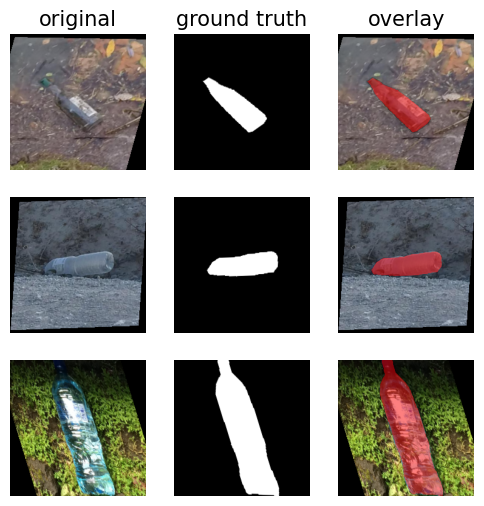

In [13]:
# Plot a sample of augmented training images
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=3, figsize=2)

## 7) Fitting our model

### The IOU metric

The intersection-over-union (IoU) metric is a widely used metric to assess the performance of an image segmentation model. It measures the overlap between the predicted segmentation mask and the ground truth mask for an image. IoU ranges from 0 to 1, with 0 meaning no overlap and 1 meaning a perfect overlap.

![iou](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2016/09/iou_examples.png?lossy=2&strip=1&webp=1)

*Adrian Rosebrock, "Intersection over union for object detection" ([link](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/))*

### Compiling and fitting the model

In [14]:
# Import functions
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded

Using a model checkpoint, we will save the model weights each time the thresholded IOU improves on the validation set images.

In [15]:
# Create a checkpoint for our U-net model
model_path = "{}/{}/{}".format(saved_models_path,"widen_param_0.05","segm_model.h5")

callback_checkpoint = ModelCheckpoint(
    model_path,
    verbose=1,
    monitor='val_iou_thresholded',
    mode='max',
    save_best_only=True,
)

We will use a binary cross-entropy loss function, since this is a pixel-level binary classification problem.

Our data generator provides the model with training data in batches, with each batch consisting of three input images and masks. Our generator provides 300 batches per epoch, and the model is trained for 25 epochs. As a reminder, there are 178 images in the training set, so each epoch will see at least one version of each image. This allows the model to slowly improve its performance over 25 iterations.

In [16]:
# Compile model
unet_model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

We set a random seed for maximum reproducibility.

In [17]:
# Set seed
tf.keras.utils.set_random_seed(1)

Finally, we fit our convolutional neural network with a U-net architecture.

In [18]:
# Fit model
history = unet_model.fit(
    train_gen,
    steps_per_epoch=300,
    validation_data=(x_val, y_val),
    epochs=25,
    callbacks=[callback_checkpoint],
    verbose=1
)

Epoch 1/25
300/300 [==============================] - ETA: 0s - loss: 0.3180 - iou: 0.3656 - iou_thresholded: 0.4878

2024-05-11 11:39:04.557915: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.
2024-05-11 11:39:04.658899: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.



Epoch 1: val_iou_thresholded improved from -inf to 0.50106, saving model to /home/jovyan/workspace/taco-image-analysis/saved_models/widen_param_0.05/segm_model.h5
300/300 [==============================] - 240s 794ms/step - loss: 0.3180 - iou: 0.3656 - iou_thresholded: 0.4878 - val_loss: 0.4242 - val_iou: 0.2901 - val_iou_thresholded: 0.5011
Epoch 2/25
300/300 [==============================] - ETA: 0s - loss: 0.2446 - iou: 0.4740 - iou_thresholded: 0.6044

2024-05-11 11:42:55.542554: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.
2024-05-11 11:42:55.644126: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.



Epoch 2: val_iou_thresholded improved from 0.50106 to 0.58979, saving model to /home/jovyan/workspace/taco-image-analysis/saved_models/widen_param_0.05/segm_model.h5
300/300 [==============================] - 231s 770ms/step - loss: 0.2446 - iou: 0.4740 - iou_thresholded: 0.6044 - val_loss: 0.2408 - val_iou: 0.4426 - val_iou_thresholded: 0.5898
Epoch 3/25
300/300 [==============================] - ETA: 0s - loss: 0.2229 - iou: 0.5106 - iou_thresholded: 0.6320

2024-05-11 11:46:47.637310: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.



Epoch 3: val_iou_thresholded did not improve from 0.58979
300/300 [==============================] - 234s 780ms/step - loss: 0.2229 - iou: 0.5106 - iou_thresholded: 0.6320 - val_loss: 0.2451 - val_iou: 0.4426 - val_iou_thresholded: 0.5763
Epoch 4/25
300/300 [==============================] - ETA: 0s - loss: 0.2019 - iou: 0.5436 - iou_thresholded: 0.6661
Epoch 4: val_iou_thresholded improved from 0.58979 to 0.60220, saving model to /home/jovyan/workspace/taco-image-analysis/saved_models/widen_param_0.05/segm_model.h5
300/300 [==============================] - 231s 770ms/step - loss: 0.2019 - iou: 0.5436 - iou_thresholded: 0.6661 - val_loss: 0.2351 - val_iou: 0.4769 - val_iou_thresholded: 0.6022
Epoch 5/25
300/300 [==============================] - ETA: 0s - loss: 0.1891 - iou: 0.5676 - iou_thresholded: 0.6835
Epoch 5: val_iou_thresholded improved from 0.60220 to 0.62541, saving model to /home/jovyan/workspace/taco-image-analysis/saved_models/widen_param_0.05/segm_model.h5
300/300 [====

In [19]:
# Path to save model history
history_path = "{}/{}/{}".format(saved_models_path,"widen_param_0.05","segm_model_history.csv")

# Save model history
with open(history_path, mode='w') as f:
    pd.DataFrame(history.history).to_csv(f)

By the 25th epoch, the highest thresholded IOU achieved on the validation set is close to **70%**.

With an increasing number of epochs, we can see that the training loss keeps decreasing while the validation loss hovers at around the same level. Our training IOU metric also keeps increasing, which shows that the model is learning weights that almost perfectly segment the bottles in the training set. The thresholded IOU on the validation set, however, has stopped increasing, a sign of overfitting.

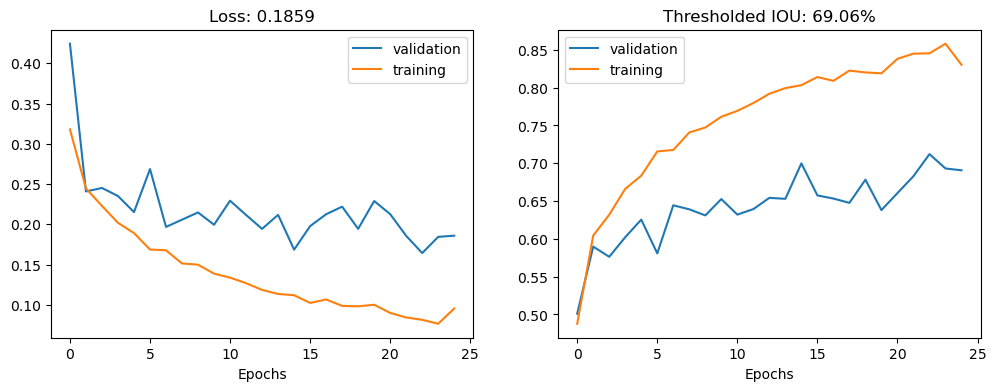

In [20]:
# Plot the training and validation curves
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Loss function
ax1.set_title("Loss: {:.4f}".format(history.history["val_loss"][-1]))
ax1.plot(history.history["val_loss"], label="validation")
ax1.plot(history.history["loss"], label="training")
ax1.set_xlabel("Epochs")
ax1.legend()

# IOU
ax2.set_title("Thresholded IOU: {:.2f}%".format(history.history["val_iou_thresholded"][-1] * 100))
ax2.plot(history.history["val_iou_thresholded"], label="validation")
ax2.plot(history.history["iou_thresholded"], label="training")
ax2.set_xlabel("Epochs")
ax2.legend()

# Plot
plt.show()

## 8) Assessing performance on the test set

Finally, we can segment the images in our test set using the model we just trained.

In [21]:
# Load weights from saved model
unet_model.load_weights(model_path)

In [22]:
# Generate predictions on the held-out test set
y_pred = unet_model.predict(x_test)

1/1 [==============================] - 2s 2s/step


In order to use the use the 'iou_thresholded' function, we need to convert both the masks and the prediction arrays into floats. We then proceed to predict the thresholded IOUs for the 25 images in the test set.

In [23]:
# Format predictions
y_pred = y_pred.astype(np.float32) #y_pred are the predicted image masks on the testing set
y_test_float = y_test.astype(np.float32) #y_test are the ground truth masks aside for the testing set

In [24]:
# Compute IOU for test set images
test_set_thresholded_ious = [iou_thresholded(y_true=x,y_pred=y).numpy() for x, y in zip(y_test_float,y_pred)]

In [25]:
# Descriptive statistics on the IOU
pd.Series(test_set_thresholded_ious).describe()

count    25.000000
mean      0.764144
std       0.205199
min       0.244418
25%       0.666920
50%       0.862357
75%       0.912947
max       0.964432
dtype: float64

The thresholded IOUs have a wide range.

In [26]:
# Show lowest IOU
lowest_iou = pd.Series(test_set_thresholded_ious).idxmin()
print("The lowest IOU in the test set is {:.2f}".format(test_set_thresholded_ious[lowest_iou]))

The lowest IOU in the test set is 0.24


We can see that, in the case of the worst prediction, the contour of the bottle is difficult to make out against the object background.

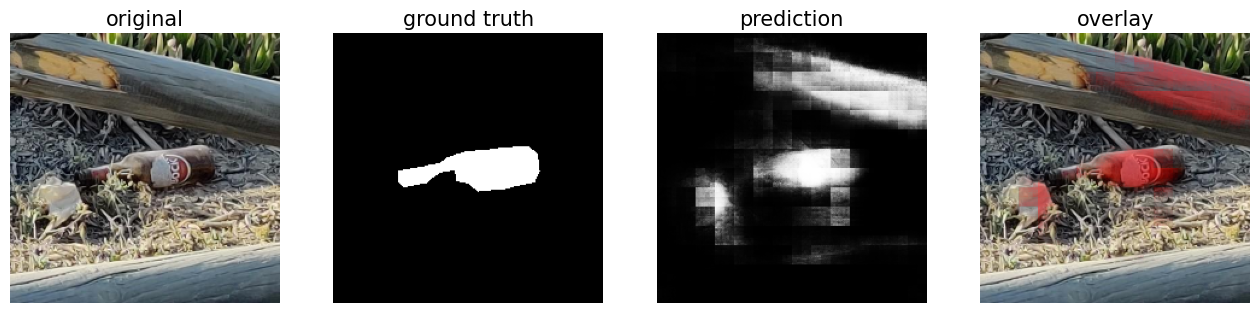

In [27]:
# Show image with the lowest IOU
plot_imgs(org_imgs=np.expand_dims(x_test[lowest_iou,:,:,:],axis=0),
          mask_imgs=np.expand_dims(y_test[lowest_iou,:,:,:],axis=0),
          pred_imgs=np.expand_dims(y_pred[lowest_iou,:,:,:],axis=0), nm_img_to_plot=1)

In [28]:
# Show highest IOU
highest_iou = pd.Series(test_set_thresholded_ious).idxmax()
print("The highest IOU in the test set is {:.2f}".format(test_set_thresholded_ious[highest_iou]))

The highest IOU in the test set is 0.96


In contrast, the image with the highest IOU is a much 'cleaner' image where the contours of the bottle are clearly discernible and there are no background elements which might lead pixels to being misclassified.

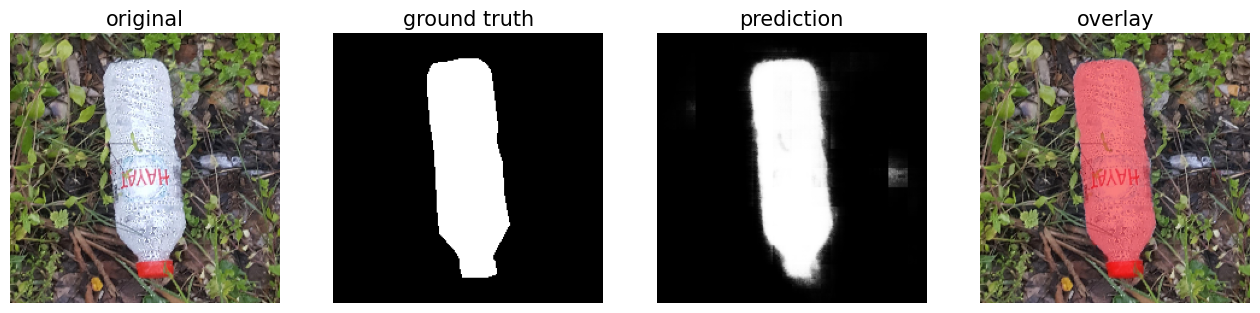

In [29]:
# Show image with the highest IOU
plot_imgs(org_imgs=np.expand_dims(x_test[highest_iou,:,:,:],axis=0),
          mask_imgs=np.expand_dims(y_test[highest_iou,:,:,:],axis=0),
          pred_imgs=np.expand_dims(y_pred[highest_iou,:,:,:],axis=0), nm_img_to_plot=1)